In [3]:
import pandas as pd
import numpy as np
#import seaborn as sb
import matplotlib.pyplot as plt

from fastai.collab import CollabDataLoaders, collab_learner
from fastai.tabular.all import *

from statistics import stdev, variance
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

## Exploratory Analysis

In [4]:
# Import of taining and test data
train = pd.read_csv("dados/train.csv")
test = pd. read_csv("dados/test.csv")
jokes = pd.read_csv("dados/jokes.csv")
print("Train " + str(train.shape))
print("Test " + str(test.shape))

Train (1092059, 4)
Test (537880, 3)


In [5]:
train.head()

,id,user_id,joke_id,Rating
0,31030_110,31030,110,2.750
1,16144_109,16144,109,5.094
2,23098_6,23098,6,-6.438
3,14273_86,14273,86,4.406
4,18419_134,18419,134,9.375


In [6]:
jokes.head()

,joke_id,joke_text
0,1,"Q. What's O. J. Simpson's web address? A. Slash, slash, backslash, slash, slash, escape."
1,2,How many feminists does it take to screw in a light bulb? That's not funny.
2,3,Q. Did you hear about the dyslexic devil worshiper? A. He sold his soul to Santa.
3,4,"They asked the Japanese visitor if they have elections in his country. ""Every morning,"" he answers."
4,5,Q: What did the blind person say when given some matzah? A: Who the hell wrote this?


In [6]:
train["joke_text"] = train.joke_id.apply(lambda x: jokes.loc[jokes.joke_id == x, "joke_text"][x-1])
test["joke_text"] = test.joke_id.apply(lambda x: jokes.loc[jokes.joke_id == x, "joke_text"][x-1])

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092059 entries, 0 to 1092058
Data columns (total 4 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   id       1092059 non-null  object 
 1   user_id  1092059 non-null  int64  
 2   joke_id  1092059 non-null  int64  
 3   Rating   1092059 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 33.3+ MB


In [8]:
# Cheching uniqueness of data
train.select_dtypes(["int64", "float64", "object"]).nunique().sort_values().to_frame().T

,joke_id,Rating,user_id,id
0,139,641,40863,1092059


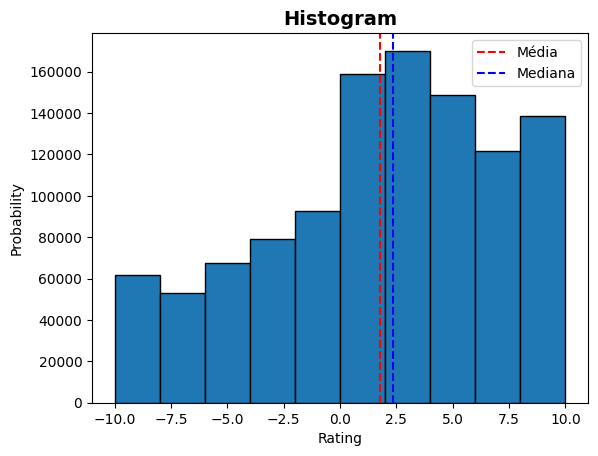

In [9]:
#plt.figure(figsize=(8, 6))
plt.hist(train.Rating, edgecolor="black")
plt.title("Histogram", fontweight="bold", fontsize=14)
plt.xlabel("Rating")
plt.ylabel("Probability")
plt.axvline(train.Rating.mean(), color="red", linestyle="--")
plt.axvline(train.Rating.median(), color="blue", linestyle="--")
plt.legend(title="", labels=["Média","Mediana"], ncol=1, loc="best")
plt.show()

In [10]:
#
stdev(train.Rating)

5.2308597557955006

In [11]:
#
variance(train.Rating)

27.361893784800966

## Data Pre-Processing

### Split & Scaling

In [ ]:
X = train.drop(["Rating"], axis=1)
y = train.Rating

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=2) 

In [4]:
sc = StandardScaler()
for col in ("user_id", "joke_id", "Rating"):
    X[col] = sc.fit_transform(X[[col]])

X.head()

,user_id,joke_id,Rating
0,0.874570,1.042180,0.189569
1,-0.383722,1.019513,0.637679
2,0.204089,-1.315214,-1.566931
3,-0.541876,0.498166,0.506151
4,-0.191420,1.586194,1.456091


## Models

In [13]:
train = train.drop(["id"], axis=1)
train.head()

,user_id,joke_id,Rating
0,31030,110,2.750
1,16144,109,5.094
2,23098,6,-6.438
3,14273,86,4.406
4,18419,134,9.375


In [37]:
dls = CollabDataLoaders.from_df(
    train, 
    user_name="user_id", 
    item_name="joke_id", 
    rating_name="Rating", 
    bs=2000,
    valid_pct=0.2, 
    shuffle_train=True,
    seed=2
)

dls.show_batch()

,user_id,joke_id,Rating
0,34442,115,-9.000
1,9170,25,5.594
2,15977,56,8.781
3,3819,79,5.969
4,25425,60,7.656
5,33836,80,8.125
6,1835,102,9.844
7,14403,2,1.250
8,34980,52,-4.625
9,28947,23,9.188


In [15]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))
    
def RMSELossFlat(*args, axis=-1, floatify=True, **kwargs):
    return BaseLoss(RMSELoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)

In [47]:
model = collab_learner(dls, use_nn=False, y_range=(-10. ,10.), n_factors=250, loss_func=RMSELossFlat())

SuggestedLRs(valley=0.0003981071640737355)

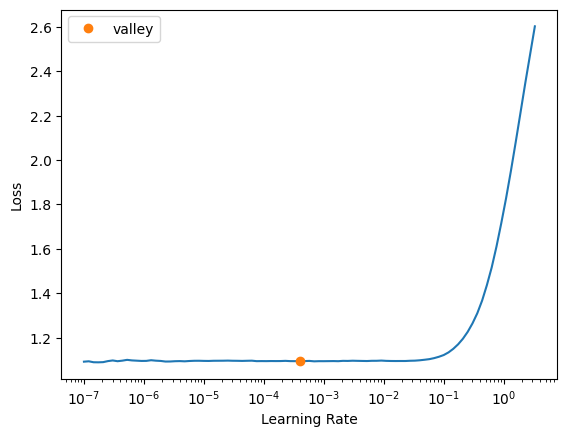

In [35]:
model.lr_find()

In [53]:
model.fit_one_cycle(n_epoch=35, lr_max=10e-2, wd=0.3)

epoch,train_loss,valid_loss,time
0,1.375863,4.137762,00:46
1,3.422408,4.331400,00:48
2,4.336032,4.554557,00:48
3,4.740074,4.800587,00:59
4,5.127922,5.192208,01:15
5,5.490827,5.534153,01:04
6,5.790657,5.787431,00:49
7,5.957973,5.955312,00:46
8,6.027506,6.039778,00:47
9,6.021982,6.013632,00:49


In [54]:
model.show_results()

,user_id,joke_id,Rating,Rating_pred
0,20909.0,132.0,-8.281,1.407827
1,12543.0,103.0,2.656,1.131916
2,30495.0,84.0,7.094,1.621963
3,8821.0,15.0,2.094,2.736691
4,11616.0,79.0,-1.375,1.140109
5,33991.0,46.0,5.438,5.759834
6,25076.0,5.0,4.938,-1.727879
7,10868.0,25.0,7.219,3.873819
8,40328.0,53.0,4.031,2.554638


In [55]:
pp = model.dls.test_dl(test)
preds, _ = model.get_preds(dl=pp)

## Submission

In [56]:
test["Rating"] = preds
test.loc[:, ["id", "Rating"]].to_csv("submission.csv", index=False)
test.head()

,id,user_id,joke_id,Rating
0,6194_11,6194,11,1.157151
1,19356_3,19356,3,-0.514256
2,23426_79,23426,79,4.685508
3,40030_3,40030,3,-2.414566
4,19806_115,19806,115,6.191740


In [ ]:
#submit = pd.DataFrame({"id": test.id, "Rating": preds}, columns=["id", "Rating"])
#submit.to_csv("submission_2.csv", index=False)
#submit.head()